In [1]:
%env CUDA_VISIBLE_DEVICES=2

import numpy as np
import tensorflow as tf

from craynn import *
from crayopt import *

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

env: CUDA_VISIBLE_DEVICES=2


In [2]:
from ope.datasets import kdd

In [3]:
KDD = kdd(seed=1114)()

In [4]:
dataset_pos = variable_dataset(KDD.data_pos)
dataset_test = variable_dataset(KDD.data_test, KDD.labels_test)

In [5]:
def uniform_onehot(rng, size, batch_size):
    indecies = rng.uniform(shape=(batch_size, ), minval=0, maxval=size, dtype=tf.int32)
    return tf.one_hot(indecies, depth=size, dtype=tf.float32)

def get_uniform(feature_spec, batch_size, seed=111):
    rng = tf.random.Generator.from_seed(seed=111)
    
    @tf.function(autograph=False)
    def generate():
        columns = list()
        for _, t, (min, max) in feature_spec:
            if t == 'continuous':
                column = rng.uniform(shape=(batch_size, 1), minval=0, maxval=1, dtype=tf.float32)
            elif t == 'binary':
                column = tf.cast(
                    rng.uniform(shape=(batch_size, 1), minval=0, maxval=2, dtype=tf.int32),
                    dtype=tf.float32
                )
            elif t == 'categorical':
                column = uniform_onehot(rng, size=max + 1, batch_size=batch_size)
            else:
                raise Exception('data type %s is not understood!' % (t, ))
        
            columns.append(column)
        
        return tf.concat(columns, axis=1)
    
    return generate

In [6]:
uniform = get_uniform(feature_spec=KDD.feature_spec, batch_size=32)

In [7]:
for name, t, r in KDD.feature_spec:
    if t == 'continuous':
        print('%s: %s' % (name.ljust(27), t.rjust(12)))
    elif t == 'binary':
        print('%s: %s' % (name.ljust(27), t.rjust(12)))
    else:
        print('%s: %s [%d]' % (name.ljust(27), t.rjust(12), r[1]))

duration                   :   continuous
protocol_type              :  categorical [2]
service                    :  categorical [70]
flag                       :  categorical [10]
src_bytes                  :   continuous
dst_bytes                  :   continuous
land                       :       binary
wrong_fragment             :   continuous
urgent                     :   continuous
hot                        :   continuous
num_failed_logins          :   continuous
logged_in                  :       binary
num_compromised            :   continuous
root_shell                 :   continuous
su_attempted               :   continuous
num_root                   :   continuous
num_file_creations         :   continuous
num_shells                 :   continuous
num_access_files           :   continuous
num_outbound_cmds          :   continuous
is_host_login              :       binary
is_guest_login             :       binary
count                      :   continuous
srv_count           

In [8]:
n = 48

net = network((None, KDD.data_pos.shape[1]))(
    dense(4 * n),
    dense(3 * n),
    dense(2 * n),
    dense(n),
    dense(1, activation=linear()),
    flatten(1)
)

In [9]:
optimizer = tf_updates.adam()(net.variables(trainable=True))

In [10]:
@tf.function(autograph=False)
def step():
    X_pos, = dataset_pos.batch(32)
    X_gen = uniform()
    
    with optimizer:
        p_pos = net(X_pos)
        p_gen = net(X_gen)
        
        loss_pos = tf.nn.softplus(-p_pos)
        loss_gen = tf.nn.softplus(p_gen)
        
        loss = tf.reduce_mean(loss_pos) + 0.05 * tf.reduce_mean(loss_gen) + 1e-4 * net.reg_l2()
        
        return optimizer(loss)

In [ ]:
from sklearn.metrics import roc_auc_score

losses = list()
scores = list()

for _ in tqdm(range(8)):
    net.reset()
    train.normalize_weights(net, dataset_test[:1024])

    ls = train.iterate(step, n_iterations=len(dataset_pos) // 32, n_epoches=8, progress=tqdm)
    losses.append(ls)

    predictions, = dataset_test.eval(net, batch_size=1024)
    
    score = roc_auc_score(KDD.labels_test, predictions)
    scores.append(score)

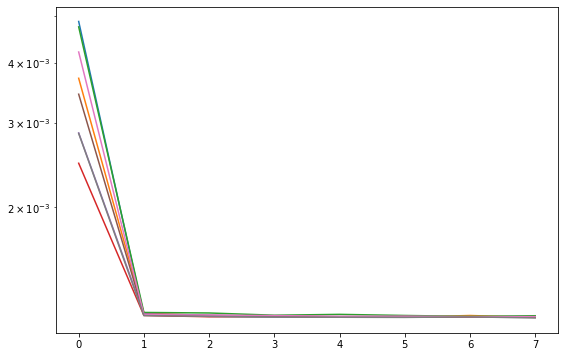

In [16]:
plt.figure(figsize=(9, 6))
for ls in losses:
    plt.plot(np.mean(ls, axis=1))
plt.yscale('log')
plt.show()

In [17]:
scores

[0.9773840141275948,
 0.9778643672553712,
 0.9776754398998289,
 0.9778231164696933,
 0.9710871400181045,
 0.974677544535189,
 0.9781963158566909,
 0.9748326386641021]

In [18]:
np.mean(scores), np.std(scores, ddof=1)

(0.9761925721033218, 0.0024870280099946523)

In [19]:
print('brute-force OPE: %.3lf +- %.3lf' % (np.mean(scores), np.std(scores, ddof=1)))

brute-force OPE: 0.976 +- 0.002
